In [2]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.datasets import cifar10
from collections import Counter
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

### Reproducibility

In [3]:
SEED = 22
np.random.seed(SEED)
tf.random.set_seed(SEED)

### Set class number to train for

In [4]:
KEEP_CLASS_NUMBER = 7

### General functions

In [5]:
def get_class_summary(y):
    y_flat = y.flatten() 
    counter = Counter(y_flat)
    return counter

In [6]:
def plot_distribution(class_counts):
    labels, counts = zip(*sorted(class_counts.items()))
    label_names = [class_names[label] for label in labels]
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=label_names, y=counts)
    plt.title('Distribution of classes')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [7]:
def show_image_grid(X, y, rows, cols, figsize):
    # Create a new figure
    plt.figure(figsize=figsize)
  
    for i in range(rows*cols):
        plt.subplot(rows, cols, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X[i])
        plt.title(class_names[y[i][0]])
    
    plt.show()

#### CNN structure

In [8]:
def build_simple_cnn(input_shape=(32, 32, 3), num_classes=KEEP_CLASS_NUMBER):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # CNN Block 1
    x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    # CNN Block 2
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    # CNN Block 3
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    cnn_output = tf.keras.layers.Flatten(name='cnn_output')(x)

    # Dense layers
    dense_1 = tf.keras.layers.Dense(128, activation='relu', name='dense_1')(cnn_output)
    dropout_1 = tf.keras.layers.Dropout(0.5)(dense_1)

    # Final layer (logits before softmax)
    logits = Dense(num_classes, name='logits')(dropout_1)
    outputs = tf.keras.layers.Softmax(name='softmax')(logits)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

#### Isolation forest

In [9]:
from sklearn.ensemble import IsolationForest

def fit_iso_forest(n_estimators, contamination, train_features, test_features, random_state=SEED):
    # Initialize the model
    iso_forest = IsolationForest(
        n_estimators=n_estimators,
        contamination=contamination,
        random_state=random_state
    )
    
    # Fit the model
    iso_forest.fit(train_features)
    
    # Predict anomalies (-1 = outlier, 1 = inlier)
    predictions = iso_forest.predict(test_features)
    
    # Get anomaly scores (the lower, the more anomalous)
    anomaly_scores = iso_forest.decision_function(test_features)

    return anomaly_scores, predictions

In [10]:
def show_anomaly_score_plot(anomaly_scores, save_path=None):
    plt.hist(anomaly_scores, bins=50)
    plt.title("Anomaly Score Distribution")
    plt.xlabel("Score")
    plt.ylabel("Frequency")
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Confusion matrix saved to {save_path}")
    plt.show()

In [11]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
def print_evaluation_report(y_true, y_pred, target_names=['Unknown (OOD)', 'Known'], labels=[-1, 1]):
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy*100:.2f}%")

    print(classification_report(y_true, y_pred, target_names=target_names))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


In [12]:
def correct_predictions_with_unknown(class_preds, predictions, fallback_class):
    all_preds = np.argmax(class_preds, axis=-1)
    y_pred = np.zeros(predictions.shape[0], dtype=int)
    
    mask = predictions != -1
    y_pred[mask] = all_preds[mask]
    y_pred[~mask] = fallback_class
    
    return y_pred

# Load dataset from library

In [13]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [14]:
print('Train Images Shape:      ', X_train.shape)
print('Train Labels Shape:      ', y_train.shape)

print('\nTest Images Shape:       ', X_test.shape)
print('Test Labels Shape:       ', y_test.shape)

Train Images Shape:       (50000, 32, 32, 3)
Train Labels Shape:       (50000, 1)

Test Images Shape:        (10000, 32, 32, 3)
Test Labels Shape:        (10000, 1)


## CIFAR-10 classes

In [15]:
original_class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
class_names = ['bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck', 'automobile', 'airplane']

In [16]:
CLASS_NUMBER = 10

## Remap labels for easier handling

In [17]:
label_mapping = {original_class_names.index(name): class_names.index(name) for name in original_class_names}

In [18]:
y_train_mapped = np.vectorize(label_mapping.get)(y_train)
y_test_mapped = np.vectorize(label_mapping.get)(y_test)

# Exclude 3 classes from training
Excluded class: airplane, automobile, truck (last in list)

# Divide into trained and unknown classes

In [19]:
keep_classes = list(range(KEEP_CLASS_NUMBER))
other_classes = list(set(range(CLASS_NUMBER)) - set(range(KEEP_CLASS_NUMBER)))

# Masks
train_keep_mask = np.isin(y_train_mapped.flatten(), keep_classes)
test_keep_mask = np.isin(y_test_mapped.flatten(), keep_classes)

train_unknown_mask = np.isin(y_train_mapped.flatten(), other_classes)
test_unknown_mask = np.isin(y_test_mapped.flatten(), other_classes)

# Apply
X_train_filtered = X_train[train_keep_mask]
y_train_filtered = y_train_mapped[train_keep_mask]

X_test_filtered = X_test[test_keep_mask]
y_test_filtered = y_test_mapped[test_keep_mask]

X_train_unknown = X_train[train_unknown_mask]
y_train_unknown = y_train_mapped[train_unknown_mask]
X_test_unknown = X_test[test_unknown_mask]
y_test_unknown = y_test_mapped[test_unknown_mask]

In [20]:
print("Train labels and counts:", get_class_summary(y_train_filtered))
print("Test labels and counts:", get_class_summary(y_test_filtered))
print("Unknown train labels and counts:", get_class_summary(y_train_unknown))
print("Unknown test labels and counts:", get_class_summary(y_test_unknown))

Train labels and counts: Counter({4: 5000, 2: 5000, 0: 5000, 5: 5000, 6: 5000, 1: 5000, 3: 5000})
Test labels and counts: Counter({1: 1000, 6: 1000, 4: 1000, 3: 1000, 5: 1000, 2: 1000, 0: 1000})
Unknown train labels and counts: Counter({7: 5000, 8: 5000, 9: 5000})
Unknown test labels and counts: Counter({9: 1000, 8: 1000, 7: 1000})


# Preprocess images

## One-hot encoding of labels

In [21]:
enc = OneHotEncoder()
y_train_enc=enc.fit_transform(y_train_filtered).toarray().astype(int)
y_test_enc=enc.transform(y_test_filtered).toarray().astype(int)

## Flow generation

In [22]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [23]:
train_flow = train_generator.flow(
    x=X_train_filtered,
    y=y_train_enc,
    batch_size=128,
    shuffle=True,
    seed=SEED,
    subset='training'
)

val_flow = train_generator.flow(
    x=X_train_filtered,
    y=y_train_enc,
    batch_size=128,
    shuffle=True,
    seed=SEED,
    subset='validation'
)

test_flow = test_generator.flow(
    x=X_test_filtered,
    y=y_test_enc,
    batch_size=128,
    shuffle=False
)

# CNN for classification

In [24]:
my_model = build_simple_cnn()

### Compile model

In [25]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)

my_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

### Load saved weights

In [26]:
my_model.load_weights('models/my_model_weights_7_class_v2.keras')

# Evaluate model on known test set

In [27]:
loss, accuracy = my_model.evaluate(test_flow, verbose=1)
print(f"Test accuracy: {accuracy*100:.2f}%, test loss: {loss:.4f}")

55/55 [==============================] - 2s 24ms/step - loss: 0.6135 - accuracy: 0.8000
Test accuracy: 80.00%, test loss: 0.6135


# Extract intermediate models

In [28]:
# Model to get CNN output (flattened)
cnn_output_model = tf.keras.Model(inputs=my_model.input, outputs=my_model.get_layer('cnn_output').output)

# Model to get first Dense output
dense_output_model = tf.keras.Model(inputs=my_model.input, outputs=my_model.get_layer('dense_1').output)

# Model to get logits (before softmax)
logits_model = tf.keras.Model(inputs=my_model.input, outputs=my_model.get_layer('logits').output)

# Construct training set for isolation forest
Use the 7-class test set plus 10% contamination of randomly generated images

In [29]:
X_train_filtered.shape[0]

35000

## Reduce training set size to 20%, no need for all

In [30]:
n_samples = int(0.2 * len(X_train_filtered))
indices = np.random.choice(len(X_train_filtered), size=n_samples, replace=False)

X_subset = X_train_filtered[indices]
y_subset = y_train_filtered[indices]

## Generate artificial anomaly data

In [31]:
artificial_N = round(X_subset.shape[0] * 0.05)
uniform_images = np.random.uniform(low=0.0, high=1.0, size=(artificial_N, 32, 32, 3)).astype(np.float32)
normal_images = np.clip(np.random.normal(loc=0.5, scale=0.5, size=(artificial_N, 32, 32, 3)).astype(np.float32), 0.0, 1.0)
contamination_images = np.concatenate((uniform_images, normal_images), axis=0)
y_contamination = (KEEP_CLASS_NUMBER) * np.ones((artificial_N * 2, 1), dtype=np.int32)

In [32]:
contamination_images.shape

(700, 32, 32, 3)

## Create training set

In [33]:
X_train_iso =np.concatenate([X_subset, contamination_images], axis=0)
y_train_iso = np.concatenate([y_subset, y_contamination], axis=0)

In [34]:
X_train_iso.shape, y_train_iso.shape

((7700, 32, 32, 3), (7700, 1))

### Flow without validation split and data augmentation

In [35]:
iso_train_flow = test_generator.flow(X_train_iso, y_train_iso, batch_size=128, shuffle=False, seed=SEED)

# Construct mixed test set

In [36]:
enc_full = OneHotEncoder()
y_test_modified = np.where(y_test_mapped >= KEEP_CLASS_NUMBER, KEEP_CLASS_NUMBER, y_test_mapped)
y_full_test_enc = enc_full.fit_transform(y_test_modified).toarray().astype(int)
y_full_test_enc.shape

(10000, 8)

In [37]:
y_is_known = np.where(y_test_mapped >= KEEP_CLASS_NUMBER, -1, 1)

In [38]:
iso_test_flow = test_generator.flow(X_test, y_full_test_enc, batch_size=128, shuffle=False, seed=SEED)

# Extract features using different layers of the CNN classifier

## Logits

In [39]:
train_features_logits = logits_model.predict(iso_train_flow, verbose=1)
test_features_logits =  logits_model.predict(iso_test_flow, verbose=1)

79/79 [==============================] - 2s 20ms/step


In [40]:
train_features_logits.shape

(7700, 7)

In [41]:
anomaly_scores, predictions = fit_iso_forest(
    n_estimators = 100, 
    contamination = 0.1, 
    train_features = train_features_logits, 
    test_features = test_features_logits
)

anomaly_scores2, predictions2 = fit_iso_forest(
    n_estimators = 100, 
    contamination = 0.1, 
    train_features = train_features_logits, 
    test_features = test_features_logits,
    random_state = 42
)

Confusion matrix saved to figures/anomaly_dist_id.png


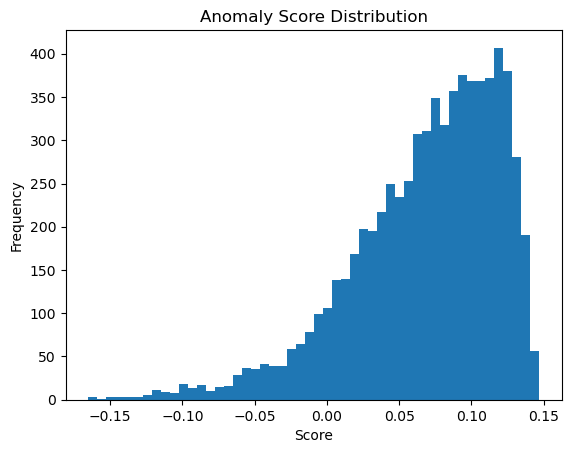

Confusion matrix saved to figures/anomaly_dist_ood.png


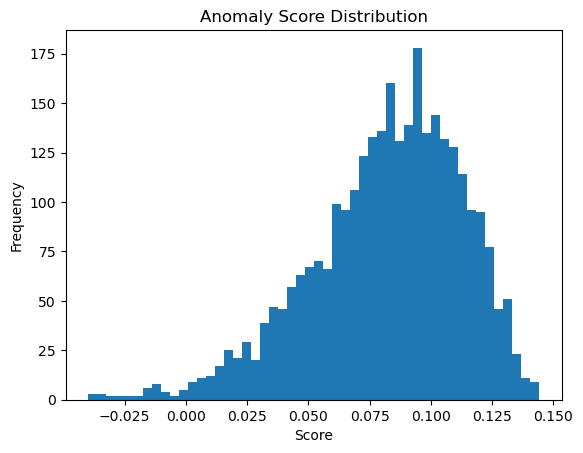


ID statistics:
  Count      : 7000
  Mean       : 0.06845
  Std Dev    : 0.05151
  Min        : -0.16501
  Max        : 0.14702
  Median (Q2): 0.07803

OOD statistics:
  Count      : 3000
  Mean       : 0.08206
  Std Dev    : 0.03082
  Min        : -0.03979
  Max        : 0.14424
  Median (Q2): 0.08562


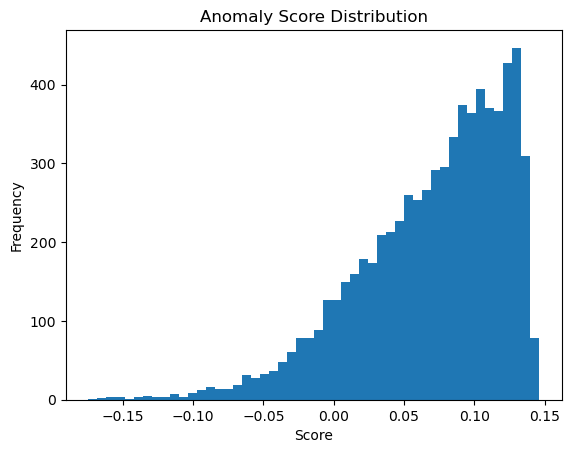

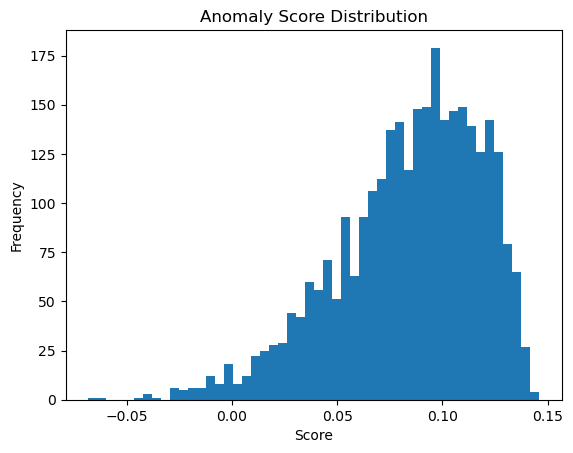


ID statistics:
  Count      : 7000
  Mean       : 0.07034
  Std Dev    : 0.05244
  Min        : -0.17436
  Max        : 0.14627
  Median (Q2): 0.08153

OOD statistics:
  Count      : 3000
  Mean       : 0.08421
  Std Dev    : 0.03435
  Min        : -0.06818
  Max        : 0.14605
  Median (Q2): 0.08963


In [42]:
def print_stats(name, scores):
    print(f"\n{name} statistics:")
    print(f"  Count      : {len(scores)}")
    print(f"  Mean       : {np.mean(scores):.5f}")
    print(f"  Std Dev    : {np.std(scores):.5f}")
    print(f"  Min        : {np.min(scores):.5f}")
    print(f"  Max        : {np.max(scores):.5f}")
    print(f"  Median (Q2): {np.median(scores):.5f}")


def print_info(scores, y_is_known, save = False):
    # Get ID and OOD masks
    id_mask = y_is_known.squeeze() == 1
    ood_mask = y_is_known.squeeze() == -1
    
    # Split the anomaly scores
    id_scores = scores[id_mask]
    ood_scores = scores[ood_mask]
    
    show_anomaly_score_plot(id_scores, "figures/anomaly_dist_id.png" if save else None )
    show_anomaly_score_plot(ood_scores, "figures/anomaly_dist_ood.png" if save else None )
    
    print_stats("ID", id_scores)
    print_stats("OOD", ood_scores)

print_info(anomaly_scores, y_is_known, save = True)
print_info(anomaly_scores2, y_is_known)

In [43]:
from tqdm import tqdm
def generate_anomaly_vectors(train_features, test_features, n_runs=30, contamination=0.1):
    anomaly_vectors = []

    for i in tqdm(range(n_runs), desc="Training Isolation Forests"):
        anomaly_scores, _ = fit_iso_forest(
            n_estimators=100,
            contamination=contamination,
            train_features=train_features,
            test_features=test_features,
            random_state=i  # change seed each time
        )
        anomaly_vectors.append(anomaly_scores)

    # Stack to shape (n_samples, n_runs)
    anomaly_matrix = np.stack(anomaly_vectors, axis=1)
    return anomaly_matrix

In [44]:
anomaly_vectors = generate_anomaly_vectors(
    train_features_logits,
    test_features_logits,
    n_runs=1000,
    contamination=0.1
)

Training Isolation Forests: 100%|██████████████████████████████████████████████████| 1000/1000 [05:37<00:00,  2.97it/s]


In [45]:
print(anomaly_vectors.shape)

(10000, 1000)


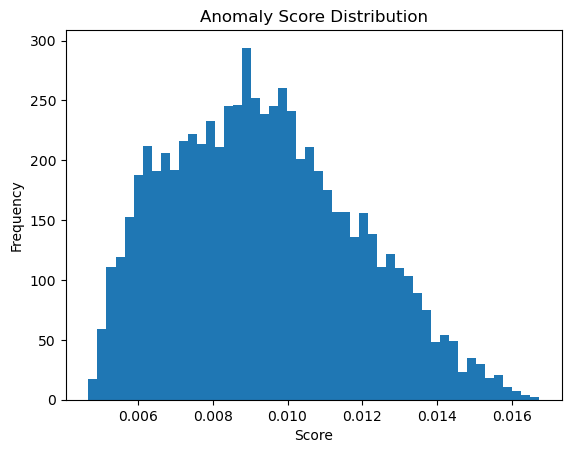

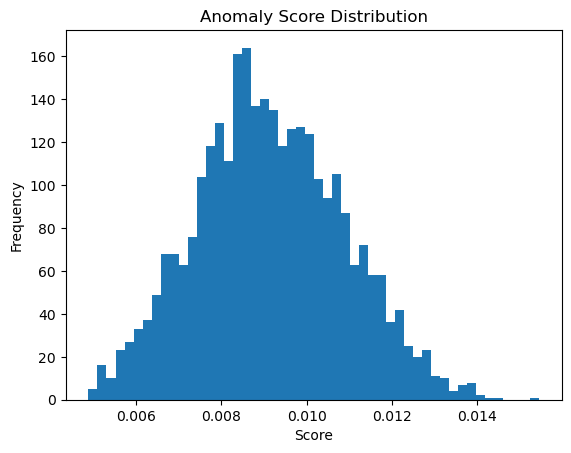


ID statistics:
  Count      : 7000
  Mean       : 0.00936
  Std Dev    : 0.00246
  Min        : 0.00467
  Max        : 0.01674
  Median (Q2): 0.00917

OOD statistics:
  Count      : 3000
  Mean       : 0.00915
  Std Dev    : 0.00173
  Min        : 0.00488
  Max        : 0.01547
  Median (Q2): 0.00905


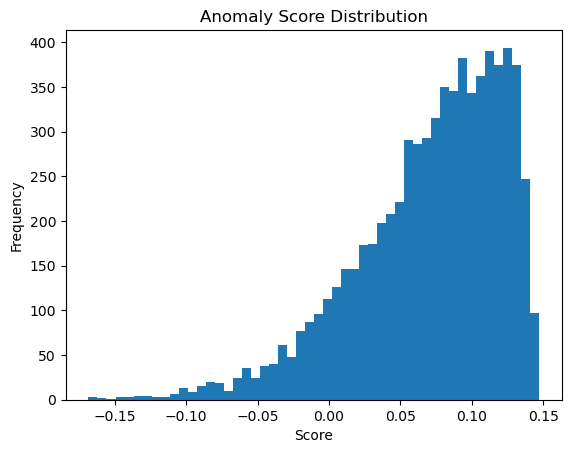

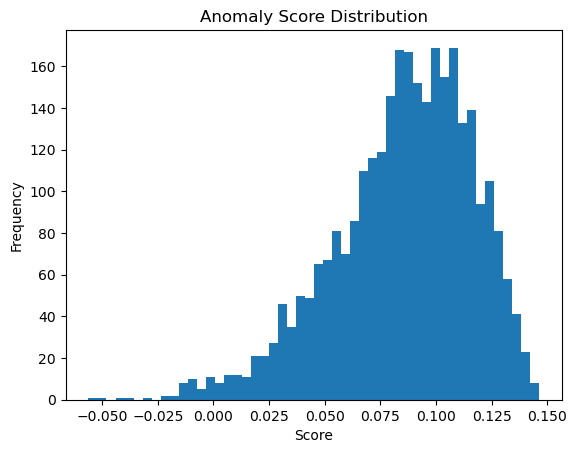


ID statistics:
  Count      : 7000
  Mean       : 0.07066
  Std Dev    : 0.05190
  Min        : -0.16832
  Max        : 0.14723
  Median (Q2): 0.08093

OOD statistics:
  Count      : 3000
  Mean       : 0.08525
  Std Dev    : 0.03127
  Min        : -0.05614
  Max        : 0.14638
  Median (Q2): 0.08902


In [46]:
sample_stds = np.std(anomaly_vectors, axis=1)
sample_means = np.mean(anomaly_vectors, axis=1)
print_info(sample_stds, y_is_known)
print_info(sample_means, y_is_known)

In [47]:
# Step 1: Compute per-sample std across components (axis=1)
sample_means = np.mean(anomaly_vectors, axis=1)

std_means = np.std(sample_means)
mean_means = np.mean(sample_means)

diff = np.abs(sample_means - mean_means)

# Step 3: Assign -1 for normal (low std), 1 for abnormal (high std)
std_based_labels = np.where(diff  <= 0.04, -1, 1)

### Display results

Accuracy: 53.71%
               precision    recall  f1-score   support

Unknown (OOD)       0.37      0.76      0.49      3000
        Known       0.81      0.44      0.57      7000

     accuracy                           0.54     10000
    macro avg       0.59      0.60      0.53     10000
 weighted avg       0.68      0.54      0.55     10000



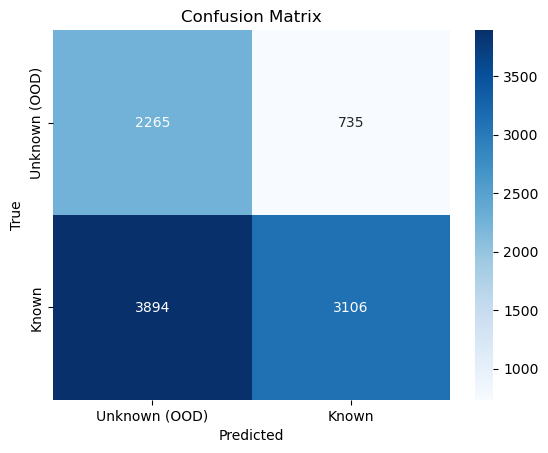

In [51]:
print_evaluation_report(y_is_known, std_based_labels)